In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p


In [66]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [67]:
# Load dataframe and add/clean columns

In [68]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [69]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df['schedule_date']=df['schedule_date'].apply(pd.to_datetime)
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df['dome'] = np.where(df['weather_detail']=='DOME', 1, 0)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [70]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 17) & (df.schedule_season>2001)]

In [71]:
# Split games into clusters


In [72]:
cluster_df = pd.read_csv('cluster_df.csv',index_col=0)

good_o_bad_d = cluster_df[cluster_df.cluster==2]
good_o_good_d = cluster_df[cluster_df.cluster==3]
bad_o_bad_d = cluster_df[cluster_df.cluster==1]
bad_o_good_d = cluster_df[cluster_df.cluster==0]

# Clustering the Data

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


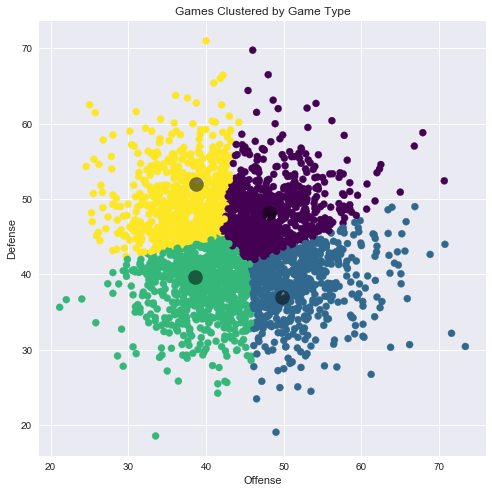

In [73]:
clusters = week5_df[['over_under_result','spread_favorite','home_favorite','last_four_difference','exp_win_difference','score_home','home_losses', 'spread_favorite','away_exp_win_pct','away_pt_diff_pg','weather_wind_mph','away_win_pct_last_4','h_ppg','a_ppg','home_exp_win_pct','home_pt_diff_pg','home_favorite','home_win_pct_last_4', 'over_under_line','total_ppg','total_points_against','weather_humidity','point_total','weather_temperature','schedule_season','a_papg','h_papg']]
clusters['per_game_difference'] = (cluster_df.h_ppg - cluster_df.a_ppg)
X = clusters[['total_points_against','total_ppg']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
clusters['cluster'] = y_kmeans
# print(len(y_kmeans[(y_kmeans == 0)]))
# print(len(y_kmeans[(y_kmeans == 1)]))
# print(len(y_kmeans[(y_kmeans == 2)]))
# print(len(y_kmeans[(y_kmeans == 3)]))
# print(len(y_kmeans[(y_kmeans == 4)]))
# print(kmeans.cluster_centers_)
centers = kmeans.cluster_centers_
plt.figure(figsize = (8,8))
plt.scatter(clusters.total_ppg,clusters.total_points_against, c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], c='black', s=200, alpha=0.5)
plt.xlabel('Offense')
plt.ylabel('Defense')
plt.title('Games Clustered by Game Type');

In [74]:
# Regression Formulas

In [75]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x,y)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
#     #conditional to plot points in diff color depending on game outcome
#     if str(y) == str(reg_df.over_under_line):
#         y1 = y[week5_df['over_under_result']==1]
#         y2 = y[week5_df['over_under_result']==0]
#         y3 = y[week5_df['over_under_result']==2]
#         x1 = x[week5_df['over_under_result']==1]
#         x2 = x[week5_df['over_under_result']==0]
#         x3 = x[week5_df['over_under_result']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
#     else:
#         y1 = y[week5_df['favorite_covered']==1]
#         y2 = y[week5_df['favorite_covered']==0]
#         y3 = y[week5_df['favorite_covered']==2]
#         x1 = x[week5_df['favorite_covered']==1]
#         x2 = x[week5_df['favorite_covered']==0]
#         x3 = x[week5_df['favorite_covered']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
        
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [76]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [77]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [78]:
# Regression Evaluations

In [79]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [80]:
def regression_evaluation(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    plt.show()
    sns.distplot(residuals)
    print(est2.params)
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [81]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [82]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

# BoxCox Transformation for Over Under Line

In [83]:
yt,max_lambda =boxcox(good_o_bad_d.over_under_line)
#yt,max_lambda
#print(min(yt),max(yt))

# Variable 1 -Total Points Against

In [84]:
xt1,x1_lam=boxcox(good_o_bad_d.total_points_against)
# xt1,x1_lam
# print(min(xt1),max(xt1))

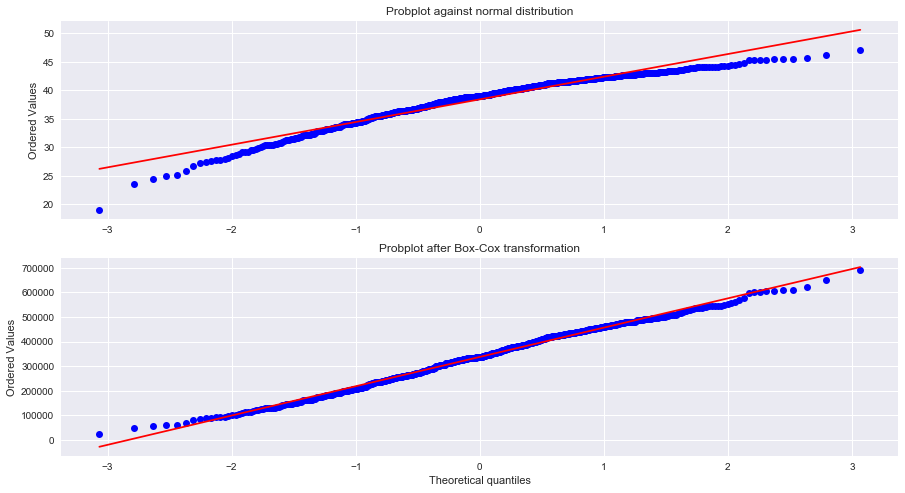

In [85]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
prob = stats.probplot(good_o_bad_d.total_points_against, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
prob = stats.probplot(xt1, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

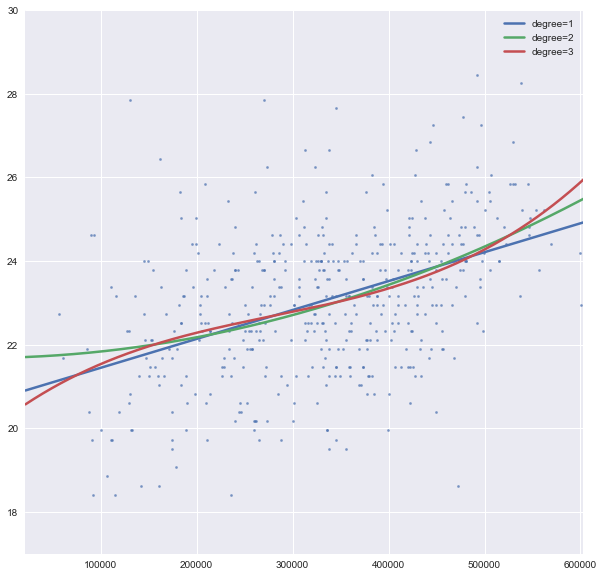

In [86]:
poly_regression(xt1, yt,[1,2,3], 21690,603084, 17,30)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     123.5
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.11e-25
Time:                        18:12:08   Log-Likelihood:                -915.31
No. Observations:                 480   AIC:                             1835.
Df Residuals:                     478   BIC:                             1843.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6720      0.139    155.616      0.0

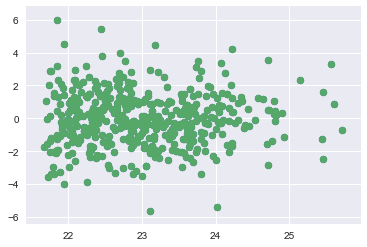

[2.16720085e+01 1.04998453e-11]
RMSE=1.6289989437003805, check =0.0


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


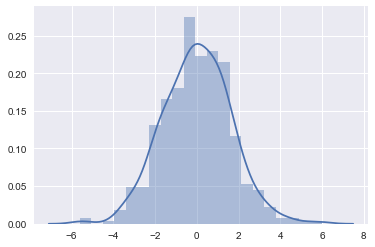

In [87]:
regression_evaluation(yt,xt1**2)

# Variable 2 - Total PPG

In [88]:
xt2,x2_lam=boxcox(good_o_bad_d.total_ppg)
# xt2,x2_lam
# print(min(xt2),max(xt2))

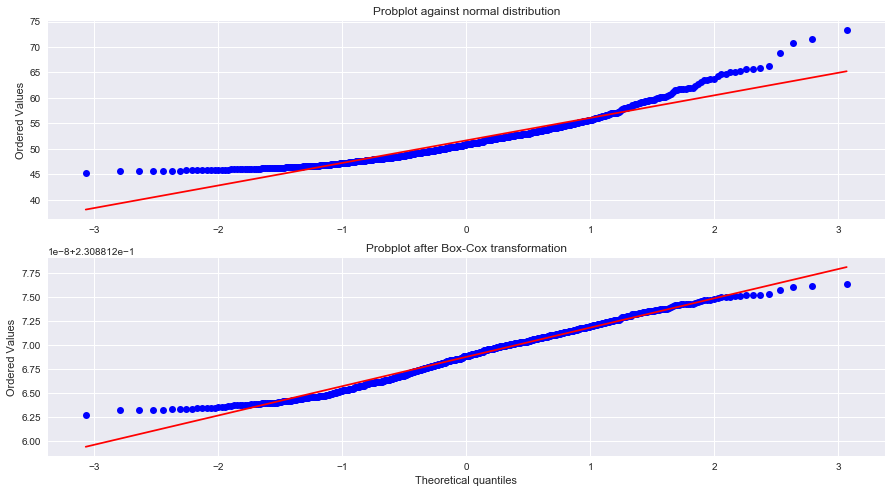

In [89]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
prob = stats.probplot(good_o_bad_d.total_ppg, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
prob = stats.probplot(xt2, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

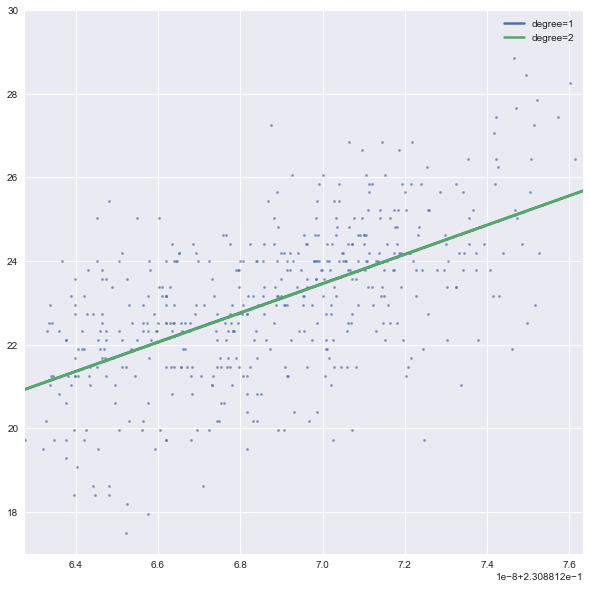

In [90]:
poly_regression(xt2,yt,[1,2],.23088126277501594,0.23088127634498215,17,30)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     256.5
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.57e-46
Time:                        18:12:10   Log-Likelihood:                -867.36
No. Observations:                 480   AIC:                             1739.
Df Residuals:                     478   BIC:                             1747.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.139e+07   5.08e+06    -16.017      0.0

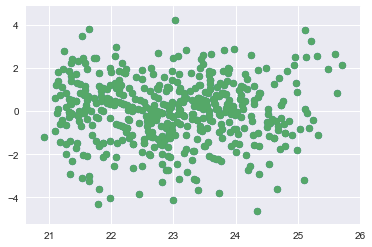

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[-8.13944636e+07  3.52538285e+08]
RMSE=1.4741227138075494, check =0.0


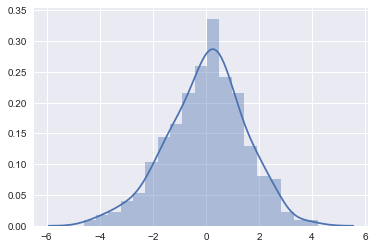

In [91]:
regression_evaluation(yt,xt2)

In [92]:
# Variable 3 - Weather Temperature

In [93]:
xt3,x3_lam=boxcox(good_o_bad_d.weather_temperature)
# xt3,x3_lam
# print(min(xt3),max(xt3))

In [94]:
#poly_regression(xt3,yt,[1,2],18,451,17,30)

In [95]:
#regression_evaluation(yt,xt3**2)

In [96]:
# Variable 4 - Weather Wind mph

In [97]:
xt4,x4_lam=boxcox(good_o_bad_d.weather_wind_mph+1)
# xt4,x4_lam
# print(min(xt4),max(xt4))

In [98]:
#poly_regression(xt4,yt,[1,2,3],0,7,17,30)

In [99]:
#regression_evaluation(yt,xt4)

In [100]:
# Variable 5 - Weather Humidity

In [101]:
xt5,x5_lam=boxcox(good_o_bad_d.weather_humidity)
# xt5,x5_lam
# print(min(xt5),max(xt5))

In [102]:
#poly_regression(xt5,yt,[1,2,3],70,4000,17,30)

In [103]:
#regression_evaluation(yt,xt5)

# Regression of over under - Good Offense, Bad Defense

In [104]:
yt,max_lambda =boxcox(good_o_bad_d.over_under_line)
xt1,x1_lam=boxcox(good_o_bad_d.total_points_against)
xt2,x2_lam=boxcox(good_o_bad_d.total_ppg)
xt3,x3_lam=boxcox(good_o_bad_d.weather_temperature)
xt4,x4_lam=boxcox(good_o_bad_d.weather_wind_mph+1)
xt5,x5_lam=boxcox(good_o_bad_d.weather_humidity)

gobd_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5]).T
gobd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity']
gobd_df.head()
len(gobd_df)

640

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     101.2
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.82e-72
Time:                        18:12:11   Log-Likelihood:                -796.17
No. Observations:                 480   AIC:                             1604.
Df Residuals:                     474   BIC:                             1629.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -6.728e+07 

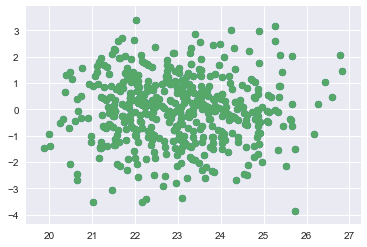

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                  -6.727919e+07
Total Points Against    4.980183e-06
Total PPG               2.914018e+08
Temp                    1.129295e-03
Wind MPH               -2.255590e-01
Humidity               -1.512304e-04
dtype: float64
RMSE=1.2709285488377138, check =0.0


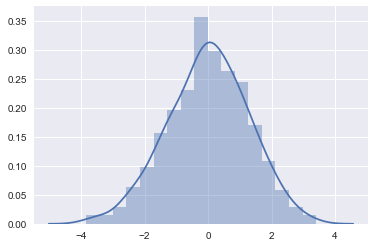

In [105]:
regression_evaluation(yt,gobd_df)

# Good Offense, Good Defense

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     135.4
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.78e-83
Time:                        18:12:11   Log-Likelihood:                 586.12
No. Observations:                 631   AIC:                            -1162.
Df Residuals:                     626   BIC:                            -1140.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.634e+07 

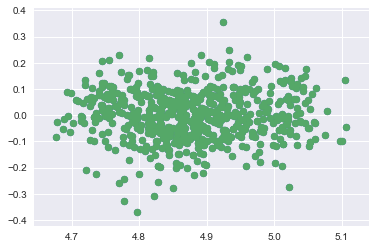

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                  -1.633614e+07
Total Points Against    4.488241e+06
Total PPG               7.210020e+07
Temp                    3.264604e-05
Wind MPH               -2.055851e-02
dtype: float64
RMSE=0.09557795486743227, check =-0.0


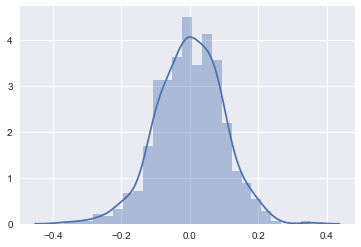

In [106]:
cluster_name = good_o_good_d

yt,max_lambda =boxcox(cluster_name.over_under_line)
xt1,x1_lam=boxcox(cluster_name.total_points_against)
xt2,x2_lam=boxcox(cluster_name.total_ppg)
xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
xt5,x5_lam=boxcox(cluster_name.weather_humidity)

gogd_df = pd.DataFrame([xt1,xt2,xt3,xt4]).T
gogd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH']
gogd_df.head()
len(gogd_df)

regression_evaluation(yt,gogd_df)

# Bad Offense, Bad Defense

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     186.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          4.03e-106
Time:                        18:12:12   Log-Likelihood:                -789.10
No. Observations:                 648   AIC:                             1588.
Df Residuals:                     643   BIC:                             1611.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.0937 

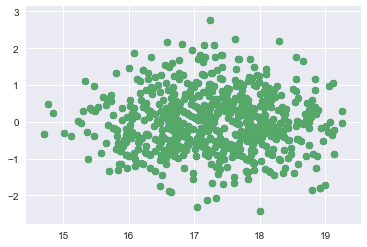

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                   1.409371e+01
Total Points Against    4.455859e-07
Total PPG               2.866647e-06
Temp                    2.335357e-03
Wind MPH               -9.971634e-02
dtype: float64
RMSE=0.8177558647986316, check =-0.0


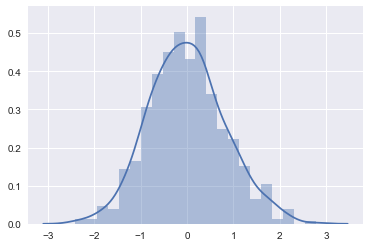

In [107]:
cluster_name = bad_o_bad_d

yt,max_lambda =boxcox(cluster_name.over_under_line)
xt1,x1_lam=boxcox(cluster_name.total_points_against)
xt2,x2_lam=boxcox(cluster_name.total_ppg)
xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
xt5,x5_lam=boxcox(cluster_name.weather_humidity)

bobd_df = pd.DataFrame([xt1,xt2,xt3,xt4]).T
bobd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH']
bobd_df.head()

regression_evaluation(yt,bobd_df)

# Bad Offense, Good Defense

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     121.8
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.26e-87
Time:                        18:12:13   Log-Likelihood:                -1545.4
No. Observations:                 572   AIC:                             3103.
Df Residuals:                     566   BIC:                             3129.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.897e+07 

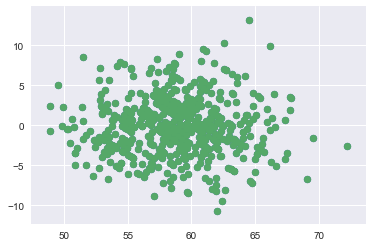

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                  -4.897439e+07
Total Points Against    2.018974e+08
Total PPG               7.055731e-05
Temp                    1.226397e-03
Wind MPH               -4.173834e-01
Humidity                2.345047e-04
dtype: float64
RMSE=3.606944235470414, check =-0.0


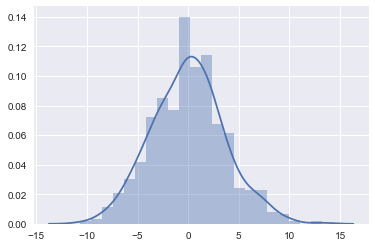

In [108]:
cluster_name = bad_o_good_d

yt,max_lambda =boxcox(cluster_name.over_under_line)
xt1,x1_lam=boxcox(cluster_name.total_points_against)
xt2,x2_lam=boxcox(cluster_name.total_ppg)
xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
xt5,x5_lam=boxcox(cluster_name.weather_humidity)

bogd_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5]).T
bogd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity']
bogd_df.head()

regression_evaluation(yt,bogd_df)

In [109]:
# cluster_name = week5_df

# yt,max_lambda =boxcox(cluster_name.over_under_line)
# xt1,x1_lam=boxcox(cluster_name.total_points_against)
# xt2,x2_lam=boxcox(cluster_name.total_ppg)
# xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
# xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
# xt5,x5_lam=boxcox(cluster_name.weather_humidity)

# noclust_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5]).T
# noclust_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity']
# noclust_df.head()

# regression_evaluation(yt,noclust_df)

In [110]:
bogd_p = bad_o_good_d.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [111]:
bogd_p['row_total'] = 0
rows = []
for index, row in bogd_p.iterrows():
    row.row_total = sum(row)
    rows.append(row)

In [112]:
ou_covered = bogd_p.over_under_result[1]
ou_no_cover = bogd_p.over_under_result[0]
ou_push = bogd_p.over_under_result[2]

In [113]:
lines = sorted(set(reg_df.over_under_line))
# x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [114]:
y_over = [ou_covered[value]/bogd_p['row_total'][value] for value in lines if value in list(bad_o_good_d.over_under_line)]
y_under = [ou_no_cover[value]/bogd_p['row_total'][value] for value in lines if value in list(bad_o_good_d.over_under_line)]
y_neither = [ou_push[value]/bogd_p['row_total'][value] for value in lines if value in list(bad_o_good_d.over_under_line)]

In [115]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# trace1 = go.Bar(
#     x=lines,
#     y=y_over,
#     name='Over'
# )
# trace2 = go.Bar(
#     x=lines,
#     y=y_under,
#     name='Under'
# )

# trace3 = go.Bar(
#     x=lines,
#     y=y_neither,
#     name='Push'
# )

# data = [trace1, trace2, trace3]
# layout = go.Layout(
#     barmode='group', title = 'Bad Offense Good Defense'
# )

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='stacked-bar')

In [116]:
bobd_p = bad_o_bad_d.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [117]:
bobd_p['row_total'] = 0
rows = []
for index, row in bobd_p.iterrows():
    row.row_total = sum(row)
    rows.append(row)

In [118]:
ou_covered = bobd_p.over_under_result[1]
ou_no_cover = bobd_p.over_under_result[0]
ou_push = bobd_p.over_under_result[2]

In [119]:
lines = sorted(set(reg_df.over_under_line))
# x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [120]:
y_over = [ou_covered[value]/bobd_p['row_total'][value] for value in lines if value in list(bad_o_bad_d.over_under_line)]
y_under = [ou_no_cover[value]/bobd_p['row_total'][value] for value in lines if value in list(bad_o_bad_d.over_under_line)]
y_neither = [ou_push[value]/bobd_p['row_total'][value] for value in lines if value in list(bad_o_bad_d.over_under_line)]

In [121]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# trace1 = go.Bar(
#     x=lines,
#     y=y_over,
#     name='Over'
# )
# trace2 = go.Bar(
#     x=lines,
#     y=y_under,
#     name='Under'
# )

# trace3 = go.Bar(
#     x=lines,
#     y=y_neither,
#     name='Push'
# )

# data = [trace1, trace2, trace3]
# layout = go.Layout(
#     barmode='group', title = 'Bad Offense Bad Defense'
# )


# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='stacked-bar')

In [122]:
gobd_p = good_o_bad_d.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [123]:
gobd_p['row_total'] = 0
rows = []
for index, row in gobd_p.iterrows():
    row.row_total = sum(row)
    rows.append(row)

In [124]:
ou_covered = gobd_p.over_under_result[1]
ou_no_cover = gobd_p.over_under_result[0]
ou_push =gobd_p.over_under_result[2]

In [125]:
lines = sorted(set(reg_df.over_under_line))
# x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [126]:
y_over = [ou_covered[value]/gobd_p['row_total'][value] for value in lines if value in list(good_o_bad_d.over_under_line)]
y_under = [ou_no_cover[value]/gobd_p['row_total'][value] for value in lines if value in list(good_o_bad_d.over_under_line)]
y_neither = [ou_push[value]/gobd_p['row_total'][value] for value in lines if value in list(good_o_bad_d.over_under_line)]

In [127]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# trace1 = go.Bar(
#     x=lines,
#     y=y_over,
#     name='Over'
# )
# trace2 = go.Bar(
#     x=lines,
#     y=y_under,
#     name='Under'
# )

# trace3 = go.Bar(
#     x=lines,
#     y=y_neither,
#     name='Push'
# )

# data = [trace1, trace2, trace3]
# layout = go.Layout(
#     barmode='group', title = 'Good Offense Bad Defense'
# )


# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='stacked-bar')